### Analyse the accuracies

In [1]:
import re
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import numpy as np

import seaborn as sns
from IPython.display import display, Markdown

<h3> Dictionary for each dataset to its txt file path 

In [17]:
experiment_to_results_path = {
    "DBLP5_NE_first": r'stats/fast_gpa/20250722/1508.txt',
    "DBLP3_NE_first": r'stats/fast_gpa/20250722/1521.txt',
    "Reddit_NE_first": r'stats/fast_gpa/20250722/1626.txt',
    "DBLP5_NE_last": r'stats/fast_gpa/20250723/1133.txt',
    "DBLP3_NE_last": r'stats/fast_gpa/20250723/1142.txt',
    "Reddit_NE_last": r'stats/fast_gpa/20250723/1152.txt',
    "DBLP5_NE_last0": r'stats/fast_gpa/20250723/1421.txt',
    "DBLP3_NE_last0": r'stats/fast_gpa/20250723/1424.txt',
    "Reddit_NE_last0": r'stats/fast_gpa/20250723/1427.txt',
    "DBLP5_NE_lastmid": r'stats/fast_gpa/20250723/1441.txt',
    "DBLP3_NE_lastmid": r'stats/fast_gpa/20250723/1455.txt',
    "Reddit_NE_lastmid": r'stats/fast_gpa/20250723/1500.txt',
    "UCI_NE_first": r'stats/fast_gpa/20250722/1711.txt',
    "UCI_NE_last": r'stats/fast_gpa/20250723/1216.txt',
}
DATASET = "DBLP5_NE_lastmid"

<h3> Function to parse each of the txt files that we ran to extract results

In [18]:
def parse_log_file(file_path):
    snapshot_to_local_accs = defaultdict(list)
    snapshot_to_global_accs = defaultdict(list)
    snapshot_aggregated_test_accs = defaultdict(list)
    snapshot_to_class_distribution = {}
    snapshot_to_best_round_metrics = {}
    snapshot_to_subgraph_num_and_distribution = {}

    snapshot_to_cut_edges = defaultdict(int)
    snapshot_to_edges = defaultdict(int)
    with open(file_path, 'r') as f:
        snapshot = None
        curr_local_list = []
        aggre_test_accs = []
        for line in f:
            snapshot_num_search = re.search(r"Snapshot (\d+)", line)
            if snapshot_num_search is not None:
                snapshot = int(snapshot_num_search.group(1))

            if '@Cloud> accuracy' in line:
                round_global_acc = re.search(r"accuracy\s*=\s*([+-]?\d*\.\d+)", line)
                if round_global_acc is not None:
                    global_acc = float(round_global_acc.group(1))
                    snapshot_to_global_accs[snapshot].append(global_acc)


            if '@Local> accuracy' in line:
                snapshot_match_list = re.search(r"\[(.*?)\]", line)
                if snapshot_match_list is not None:
                    curr_local_list.append([float(i) for i in snapshot_match_list.group(1).split(', ') if float(i) > 0])
            else:
                if curr_local_list != []:
                    snapshot_to_local_accs[snapshot].append(curr_local_list)
                    curr_local_list = []
                    
            if "Test Accuracy is" in line:
                snapshot_test_acc_match = re.search(r"Test Accuracy is (\d+\.\d+)", line)
                if snapshot_test_acc_match is not None:
                    aggre_test_accs.append(float(snapshot_test_acc_match.group(1)))
            else:
                if aggre_test_accs != []:
                    snapshot_aggregated_test_accs[snapshot].append(aggre_test_accs)
                    aggre_test_accs = []

            if "Subgraph" in line:
                subgraph_dict_match = re.search(r"Subgraph\s+(\d+):\s+(\{(?:\s*\d+\s*:\s*\d+\s*,?)+\})", line)
                if subgraph_dict_match is not None:
                    if snapshot not in snapshot_to_class_distribution:
                        snapshot_to_class_distribution[snapshot] = {}
                    snapshot_to_class_distribution[snapshot].update({int(subgraph_dict_match.group(1)):eval(subgraph_dict_match.group(2))})

            if "Best Round" in line:
                best_line_match = re.search(r"defaultdict\(None, ({.*})\)", line)
                if best_line_match is not None:
                    snapshot_to_best_round_metrics[snapshot] = eval(best_line_match[1])

            if "Client" in line and "training" in line:
                client_edges_line_match = re.search(r"Client (\d+) has (\d+) positive training edges", line)
                if client_edges_line_match is not None:
                    if snapshot not in snapshot_to_subgraph_num_and_distribution:
                        snapshot_to_subgraph_num_and_distribution[snapshot] = {}
                    snapshot_to_subgraph_num_and_distribution[snapshot].update({int(client_edges_line_match.group(1)):int(client_edges_line_match.group(2))})

            if "cut edges" in line:
                cut_edge_match = re.search(r"Total number of cut edges: (\d+)", line)
                if cut_edge_match is not None:
                    snapshot_to_cut_edges[snapshot] = int(cut_edge_match.group(1))

            if "A total" in line:
                edges_match = re.search(r"A total of (\d+) training edges", line)
                if edges_match is not None:
                    snapshot_to_edges[snapshot] = int(edges_match.group(1))

    return snapshot_to_local_accs, snapshot_to_global_accs, \
        snapshot_aggregated_test_accs, snapshot_to_class_distribution, \
        snapshot_to_best_round_metrics, snapshot_to_subgraph_num_and_distribution,\
        snapshot_to_cut_edges, snapshot_to_edges

snapshot_to_local_accs, snapshot_to_global_accs, \
snapshot_aggregated_test_accs, snapshot_to_class_distribution, \
snapshot_to_best_round_metrics, snapshot_to_subgraph_num_and_distribution,\
snapshot_to_cut_edges, snapshot_to_edges\
    = parse_log_file(experiment_to_results_path[DATASET])

## Record Time of Node Embedding Exchange

In [19]:
def extract_times_from_file(file_path):
    total_full_time = 0.0
    total_compute_time = 0.0
    total_comm_time = 0.0

    with open(file_path, 'r') as f:
        for line in f:
            if "Time taken for Full Node Embedding Exchange" in line:
                match = re.search(r"([\d.]+)$", line.strip())
                if match:
                    total_full_time += float(match.group(1))
            elif "Time taken for Server to compute NE" in line:
                match = re.search(r"([\d.]+)$", line.strip())
                if match:
                    total_compute_time += float(match.group(1))
            elif "Time taken for Communication" in line:
                match = re.search(r"([\d.]+)$", line.strip())
                if match:
                    total_comm_time += float(match.group(1))

    return total_full_time, total_compute_time, total_comm_time

def summarize_times_across_files(files):
    data = []

    for file in files:
        full, compute, comm = extract_times_from_file(experiment_to_results_path[file])
        data.append({
            'Label': file,
            # 'File': os.path.basename(file),
            'Total Full Exchange Time (s)': round(full, 4),
            'Total Compute Time (s)': round(compute, 4),
            'Total Communication Time (s)': round(comm, 4)
        })

    df = pd.DataFrame(data)
    return df

def print_time_table(files, save_path=None):
    df = summarize_times_across_files(files)
    print(df)

    if save_path:
        df.to_csv(save_path, index=False)
        print(f"\nSaved timing summary to {save_path}")
    
    return df

def plot_time_comparison(df):
    labels = df['Label']
    x = range(len(labels))

    width = 0.25

    plt.figure(figsize=(10, 6))
    plt.bar([i - width for i in x], df['Total Full Exchange Time (s)'], width=width, label='Full Exchange')
    plt.bar(x, df['Total Compute Time (s)'], width=width, label='Compute')
    plt.bar([i + width for i in x], df['Total Communication Time (s)'], width=width, label='Communication')

    plt.xticks(ticks=x, labels=labels, rotation=45)
    plt.ylabel("Total Time (s)")
    plt.title("Total Time Breakdown per Method")
    plt.legend()
    plt.tight_layout()
    plt.show()

              Label  Total Full Exchange Time (s)  Total Compute Time (s)  \
0    DBLP5_NE_first                        5.1625                  0.6631   
1     DBLP5_NE_last                        5.3772                  0.8530   
2    DBLP5_NE_last0                        0.5151                  0.0841   
3  DBLP5_NE_lastmid                        0.5275                  0.0865   

   Total Communication Time (s)  
0                        4.4994  
1                        4.5242  
2                        0.4309  
3                        0.4410  


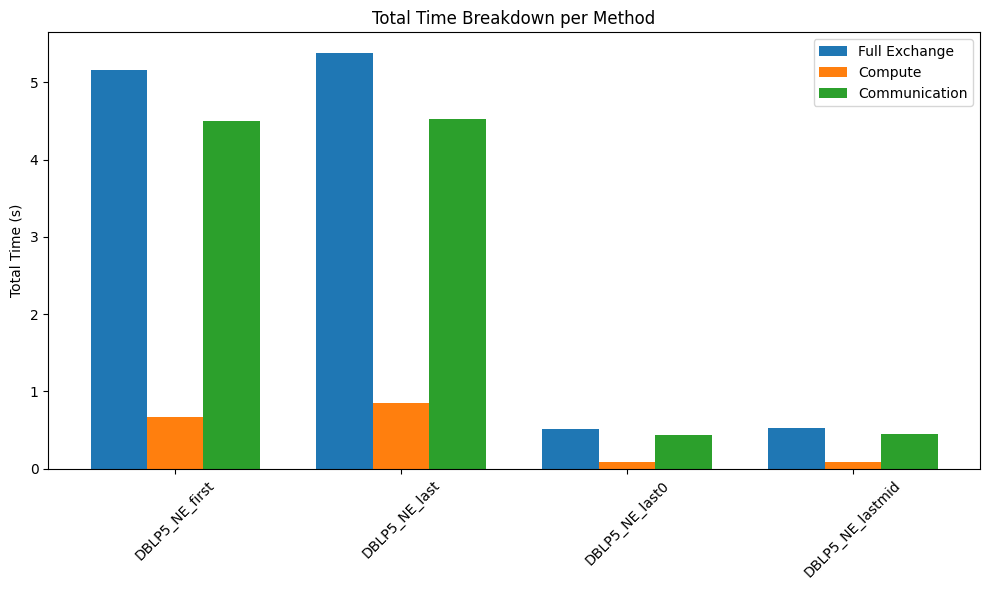

In [20]:
compare = ["DBLP5_NE_first", "DBLP5_NE_last", "DBLP5_NE_last0", "DBLP5_NE_lastmid"]

df = print_time_table(compare)
plot_time_comparison(df)

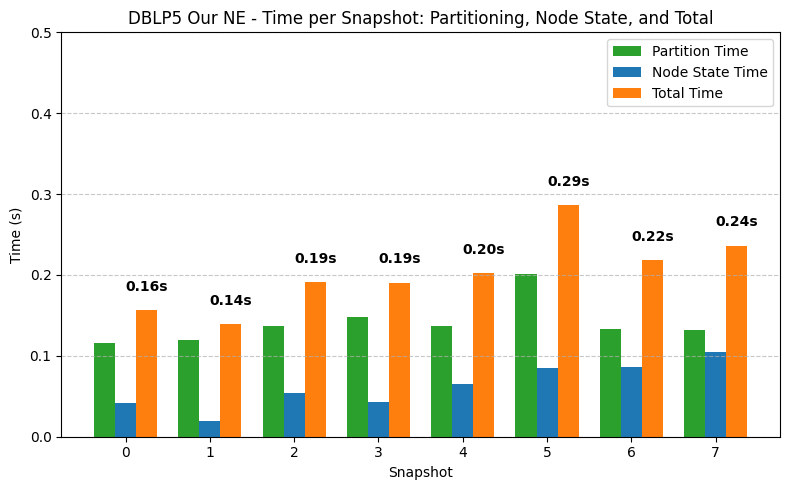

In [6]:
def parse_snapshot_times(filepath):
    snapshot_times = {}

    with open(filepath, 'r') as f:
        lines = f.readlines()

    current_snapshot = None
    for line in lines:
        line = line.strip()

        # Detect snapshot index
        snapshot_match = re.match(r"Snapshot (\d+)", line)
        if snapshot_match:
            current_snapshot = int(snapshot_match.group(1))
            snapshot_times[current_snapshot] = {
                "partition_time": 0.0,
                "node_state_time": 0.0
            }

        # Partition time
        if "Time taken to partition graph" in line and current_snapshot is not None:
            time_match = re.search(r"([0-9.]+)", line)
            if time_match:
                snapshot_times[current_snapshot]["partition_time"] = float(time_match.group(1))

        # Node state computation time
        if "Time taken for Full Node Embedding Exchange" in line and current_snapshot is not None:
            time_match = re.search(r"([0-9.]+)", line)
            if time_match:
                snapshot_times[current_snapshot]["node_state_time"] = float(time_match.group(1))

    return snapshot_times

def plot_snapshot_times(snapshot_times, dataset=""):
    snapshots = sorted(snapshot_times.keys())
    partition_times = [snapshot_times[s]['partition_time'] for s in snapshots]
    node_state_times = [snapshot_times[s]['node_state_time'] for s in snapshots]
    total_times = [p + n for p, n in zip(partition_times, node_state_times)]

    x = np.arange(len(snapshots))
    width = 0.25

    plt.figure(figsize=(8, 5))
    bars1 = plt.bar(x - width, partition_times, width, label='Partition Time', color='#2ca02c')
    bars2 = plt.bar(x, node_state_times, width, label='Node State Time', color='#1f77b4')
    bars3 = plt.bar(x + width, total_times, width, label='Total Time', color='#ff7f0e')

    # Add total time as text above the bars
    for i, total in enumerate(total_times):
        plt.text(x[i] + width, total + 0.02, f"{total:.2f}s", ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.xlabel('Snapshot')
    plt.ylabel('Time (s)')
    plt.ylim((0,0.5))
    plt.title(f'{dataset} - Time per Snapshot: Partitioning, Node State, and Total')
    plt.xticks(x, [f"{s}" for s in snapshots])
    plt.legend()
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

snapshot_times = parse_snapshot_times(experiment_to_results_path[DATASET])
plot_snapshot_times(snapshot_times, dataset="DBLP5 Our NE")

## Recording Local Client's Accuracies over Snapshots

In [21]:
def parse_snapshot_local_accuracies(filepath):
    """
    Parses local accuracy values from the log file.
    Returns:
        snapshot_to_client_accuracies: dict mapping snapshot -> client_id -> list of accuracies
            {
                0: { 0: [...], 1: [...], ..., n: [...] },
                1: { ... }
            }
    """
    snapshot_to_client_accuracies = defaultdict(lambda: defaultdict(list))
    current_snapshot = None

    with open(filepath, "r") as file:
        for line in file:
            line = line.strip()

            # Detect snapshot
            snapshot_match = re.match(r"Snapshot (\d+)", line)
            if snapshot_match:
                current_snapshot = int(snapshot_match.group(1))

            # Detect local accuracies
            if "@Local> accuracy" in line and current_snapshot is not None:
                match = re.search(r"accuracy\s*=\s*\[([^\]]+)\]", line)
                if match:
                    str_values = match.group(1).split(',')
                    float_values = [float(x.strip()) for x in str_values]
                    for client_id, acc in enumerate(float_values):
                        snapshot_to_client_accuracies[current_snapshot][client_id].append(acc)

    return snapshot_to_client_accuracies

def plot_snapshot_client_accuracies(snapshot_to_client_accuracies):
    num_snapshots = len(snapshot_to_client_accuracies)
    num_cols = 2
    num_rows = (num_snapshots + 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows), squeeze=False)
    fig.suptitle("Client Accuracy per Epoch (Grouped by Snapshot)", fontsize=16, y=0.99)

    all_handles = []
    all_labels = []
    collected_labels = set()

    for idx, (snapshot, client_to_accs) in enumerate(sorted(snapshot_to_client_accuracies.items())):
        ax = axes[idx // num_cols][idx % num_cols]

        for client_id, acc_list in sorted(client_to_accs.items()):
            line, = ax.plot(acc_list, label=f'Client {client_id}', linewidth=1)
            
            # Collect handles only once per client (avoiding duplicates)
            if f'Client {client_id}' not in collected_labels:
                all_handles.append(line)
                all_labels.append(f'Client {client_id}')
                collected_labels.add(f'Client {client_id}')

        ax.set_title(f"Snapshot {snapshot}")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Accuracy")
        ax.set_ylim(0, 1)
        ax.grid(True)

    # Adjust layout and add global legend outside plot
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    fig.legend(all_handles, all_labels, loc='center left', bbox_to_anchor=(0.92, 0.5), title="Clients")

    plt.show()

def plot_combined_accuracy_and_edges(snapshot_to_client_accuracies, snapshot_to_subgraph_num_and_distribution):
    snapshots = sorted(snapshot_to_client_accuracies.keys())
    num_snapshots = len(snapshots)
    
    # Assume 10 clients (0-9); get consistent color mapping using a colormap
    client_ids = list(range(10))
    cmap = plt.colormaps.get_cmap('tab10')  # use tab10 for categorical color palette
    client_colors = {client: cmap(client) for client in client_ids}
    
    fig, axes = plt.subplots(num_snapshots, 2, figsize=(14, 4 * num_snapshots))
    fig.suptitle("Client Accuracy and Edge Count per Snapshot", fontsize=18, y=0.99)

    if num_snapshots == 1:
        axes = np.array([axes])  # ensure 2D array even for one snapshot

    for i, snapshot in enumerate(snapshots):
        # --- Bar chart (left) ---
        edge_ax = axes[i, 0]
        edge_data = snapshot_to_subgraph_num_and_distribution.get(snapshot, {})
        clients = sorted(edge_data.keys())
        edge_counts = [edge_data[client] for client in clients]

        bars = edge_ax.bar(
            clients, edge_counts,
            color=[client_colors[client] for client in clients]
        )
        edge_ax.set_title(f"Snapshot {snapshot}: Edge Distribution")
        edge_ax.set_xlabel("Client ID")
        edge_ax.set_ylabel("#Edges")
        edge_ax.grid(True, axis='y')

        # --- Line plot (right) ---
        acc_ax = axes[i, 1]
        client_to_accs = snapshot_to_client_accuracies[snapshot]
        for client_id, acc_list in sorted(client_to_accs.items()):
            acc_ax.plot(acc_list, label=f"Client {client_id}", linewidth=1.5, color=client_colors[client_id])

        acc_ax.set_title(f"Snapshot {snapshot}: Local Accuracy over Epochs")
        acc_ax.set_xlabel("Epoch")
        acc_ax.set_ylabel("Accuracy")
        acc_ax.set_ylim(0, 1)
        acc_ax.grid(True)

        # --- Per-row legend (only for the line plot) ---
        # handles, labels = acc_ax.get_legend_handles_labels()
        # acc_ax.legend(handles, labels, loc='upper right', fontsize=9)

    # Place one legend outside all line plots (shared)
    handles, labels = axes[0, 1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 0.98), fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

local_accuracies = parse_snapshot_local_accuracies(experiment_to_results_path[DATASET])

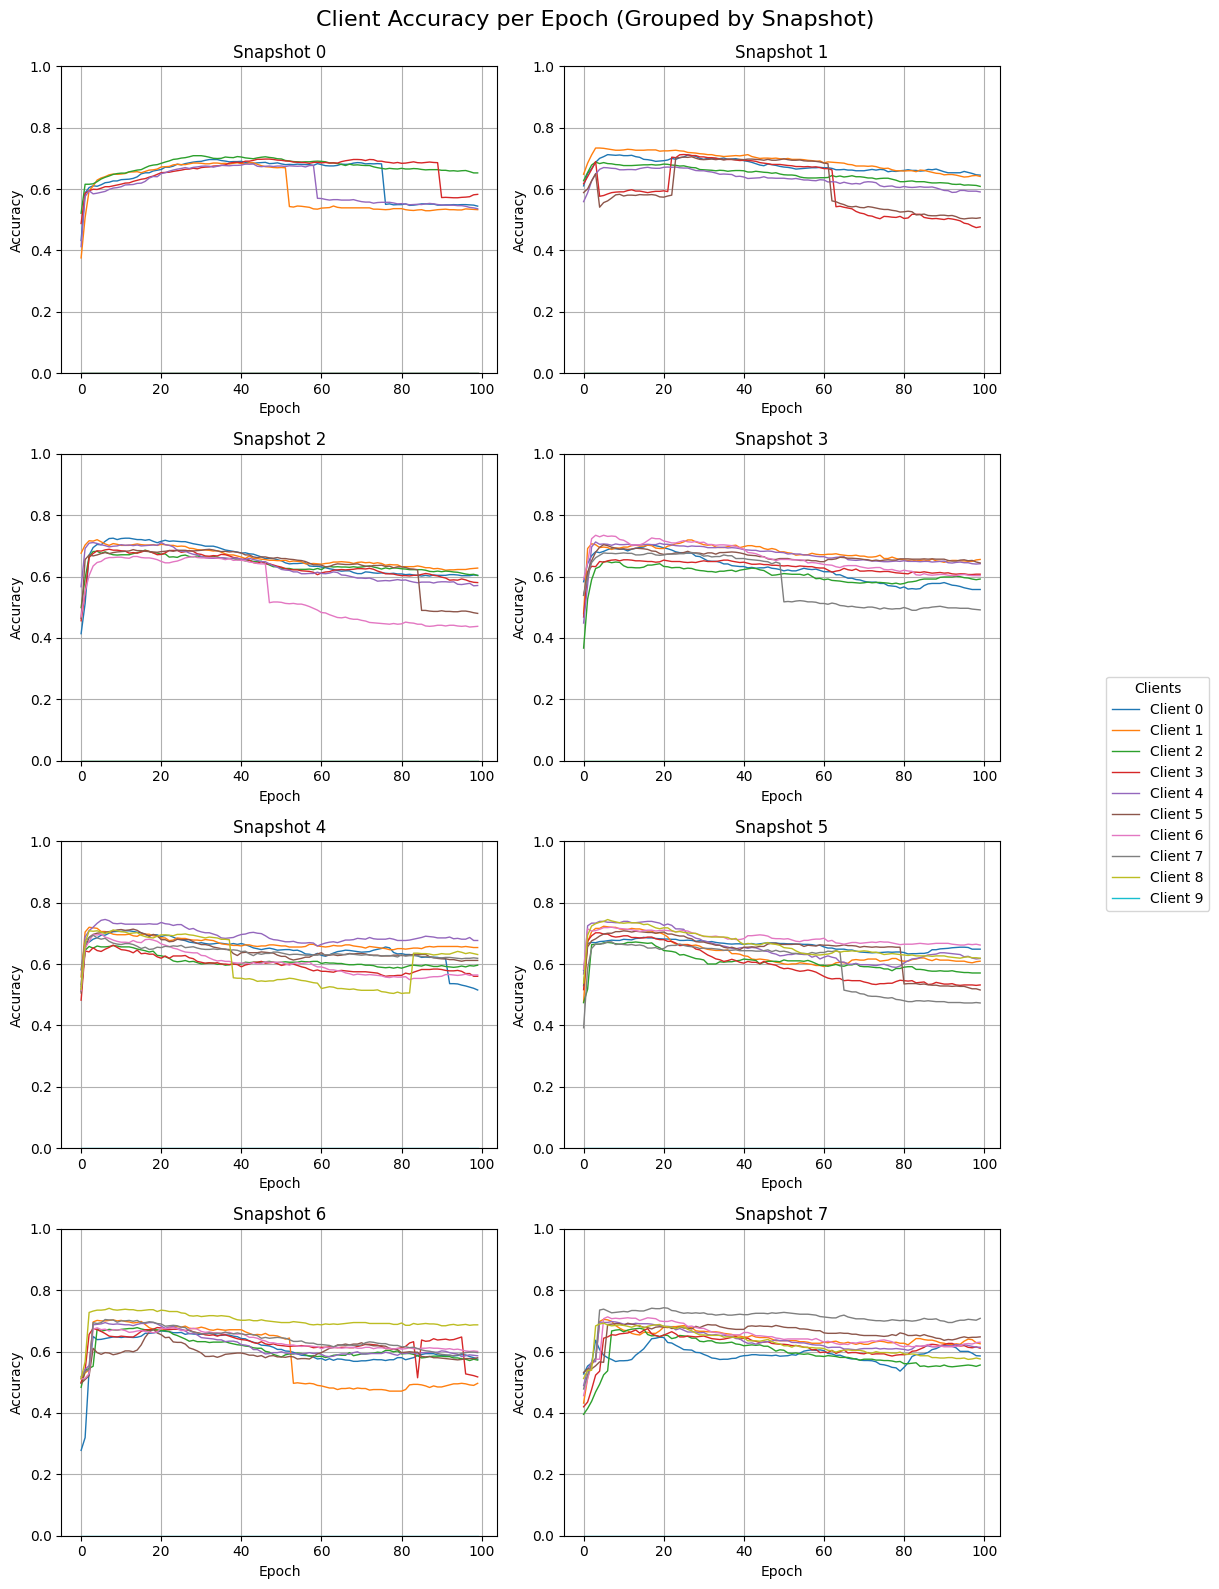

In [22]:
# plot_combined_accuracy_and_edges(local_accuracies, snapshot_to_subgraph_num_and_distribution)
plot_snapshot_client_accuracies(local_accuracies)

<h3> Take a look at the Global Accuracy over Snapshots

In [9]:
def plot_global_accuracy(snapshot_data):
    # Step 1: Flatten all values and track boundaries
    all_values = []
    snapshot_start_indices = []
    index = 0

    for snapshot_id in sorted(snapshot_data.keys()):
        rounds = snapshot_data[snapshot_id][0]
        snapshot_start_indices.append(index)
        for item in rounds:
            all_values.append(item[0])
            index += 1

    # Step 2: Plot the line with snapshot markers
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(all_values)+1), all_values, marker='o', label="Values")

    # Add vertical lines for snapshot boundaries
    for i, snapshot_start in enumerate(snapshot_start_indices):
        if snapshot_start > 0:
            plt.axvline(snapshot_start + 1, color='gray', linestyle='--', alpha=0.6)
            plt.text(snapshot_start + 1.1, max(all_values), f"Snapshot {i}", rotation=90,
                    verticalalignment='bottom', fontsize=10, color='gray')

    # Labels and title
    plt.xlabel("Rounds")
    plt.ylabel("Global Accuracy")
    plt.title("Global Accuracy over Snapshots")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

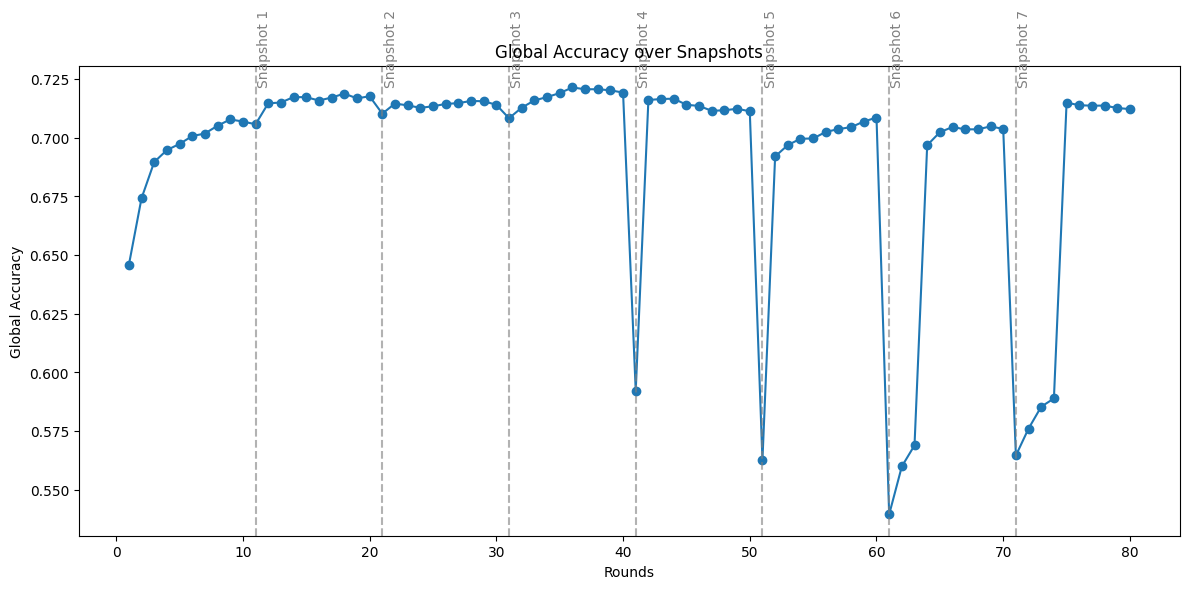

In [10]:
modified_dict = {}
for snapshot in snapshot_to_global_accs:
    modified_dict[snapshot] = [[[i] for i in snapshot_to_global_accs[snapshot]]]
    
plot_global_accuracy(modified_dict)

### Compare Multiple Approaches Global Accuracies

In [11]:
''' Only show data, without saying the best accuracies per txt file '''
def plot_multiple_global_accuracies(datas, labels):
    plt.figure(figsize=(12, 6))

    for data, label in zip(datas, labels):        
        # Flatten global accuracies across all snapshots
        all_values = []
        snapshot_start_indices = []
        index = 0

        for snapshot_id in sorted(data.keys()):
            rounds = data[snapshot_id][0]
            snapshot_start_indices.append(index)
            for item in rounds:
                all_values.append(item[0])  # Assuming item[0] is the global accuracy
                index += 1

        # Plot the global accuracy curve for this file
        plt.plot(range(1, len(all_values)+1), all_values, marker='o', label=label)

    # Plot decorations
    plt.xlabel("Rounds")
    plt.ylabel("Global Accuracy")
    plt.title("Global Accuracy over Snapshots (Multiple Strategies)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

''' Show the best accuracy per txt file, but show it on the data point '''
def plot_multiple_global_accuracies(datas, labels):
    plt.figure(figsize=(12, 6))

    for data, label in zip(datas, labels):
        # Flatten global accuracies across all snapshots
        all_values = []
        snapshot_start_indices = []
        index = 0

        for snapshot_id in sorted(data.keys()):
            rounds = data[snapshot_id][0]
            snapshot_start_indices.append(index)
            for item in rounds:
                all_values.append(item[0])  # Assuming item[0] is the global accuracy
                index += 1

        # X values for plotting
        x_values = list(range(1, len(all_values)+1))

        # Plot the line
        plt.plot(x_values, all_values, marker='o', label=label)

        # Find and highlight max accuracy
        max_acc = max(all_values)
        max_idx = all_values.index(max_acc)
        plt.scatter(x_values[max_idx], max_acc, color='red', zorder=5)
        plt.text(x_values[max_idx], max_acc + 0.005, f"{max_acc:.4f}", color='red', fontsize=9, ha='center')

    # Final plot settings
    plt.xlabel("Rounds")
    plt.ylabel("Global Accuracy")
    plt.title("Global Accuracy over Snapshots (Multiple Runs)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [12]:
''' Show the best accuracies on the legeng for clarity '''
def plot_multiple_global_accuracies(datas, labels):
    plt.figure(figsize=(12, 6))

    for data, label in zip(datas, labels):       
        # Flatten global accuracies across all snapshots
        all_values = []
        snapshot_start_indices = []
        index = 0

        for snapshot_id in sorted(data.keys()):
            rounds = data[snapshot_id][0]
            snapshot_start_indices.append(index)
            for item in rounds:
                all_values.append(item[0])  # Assuming item[0] is the global accuracy
                index += 1

        x_values = list(range(1, len(all_values)+1))

        # Find and highlight max accuracy
        max_acc = max(all_values)
        max_idx = all_values.index(max_acc)

        # Include best accuracy in the label
        label_with_acc = f"{label} (Best: {max_acc:.4f})"

        # Plot line
        plt.plot(x_values, all_values, marker='o', label=label_with_acc)

        # Optionally highlight the best point
        plt.scatter(x_values[max_idx], max_acc, color='red', zorder=5)

    # Plot formatting
    plt.xlabel("Rounds")
    plt.ylabel("Global Accuracy")
    plt.title("Global Accuracy over Snapshots (Multiple Runs)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [13]:
''' Show snapshots on the xlabel instead of rounds '''
def plot_multiple_global_accuracies_with_snapshot_xticks(datas, labels):
    plt.figure(figsize=(12, 6))

    for data, label in zip(datas, labels):
        all_values = []
        snapshot_start_indices = []
        index = 0

        for snapshot_id in sorted(data.keys()):
            rounds = data[snapshot_id][0]
            snapshot_start_indices.append(index)
            for item in rounds:
                all_values.append(item[0])  # global accuracy
                index += 1

        x_values = list(range(1, len(all_values)+1))

        # Highlight best point
        max_acc = max(all_values)
        max_idx = all_values.index(max_acc)
        label_with_acc = f"{label} (Best: {max_acc:.4f})"

        plt.plot(x_values, all_values, marker='o', label=label_with_acc)
        plt.scatter(x_values[max_idx], max_acc, color='yellow', zorder=5)

    # Set x-ticks at snapshot boundaries
    xtick_positions = [i+1 for i in snapshot_start_indices]  # +1 because x_values start from 1
    xtick_labels = [f"Snapshot {i}" for i in range(len(xtick_positions))]
    plt.xticks(ticks=xtick_positions, labels=xtick_labels, rotation=45)

    plt.xlabel("Snapshot")
    plt.ylabel("Global Accuracy")
    plt.title("Global Accuracy per Round (Labeled by Snapshot)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

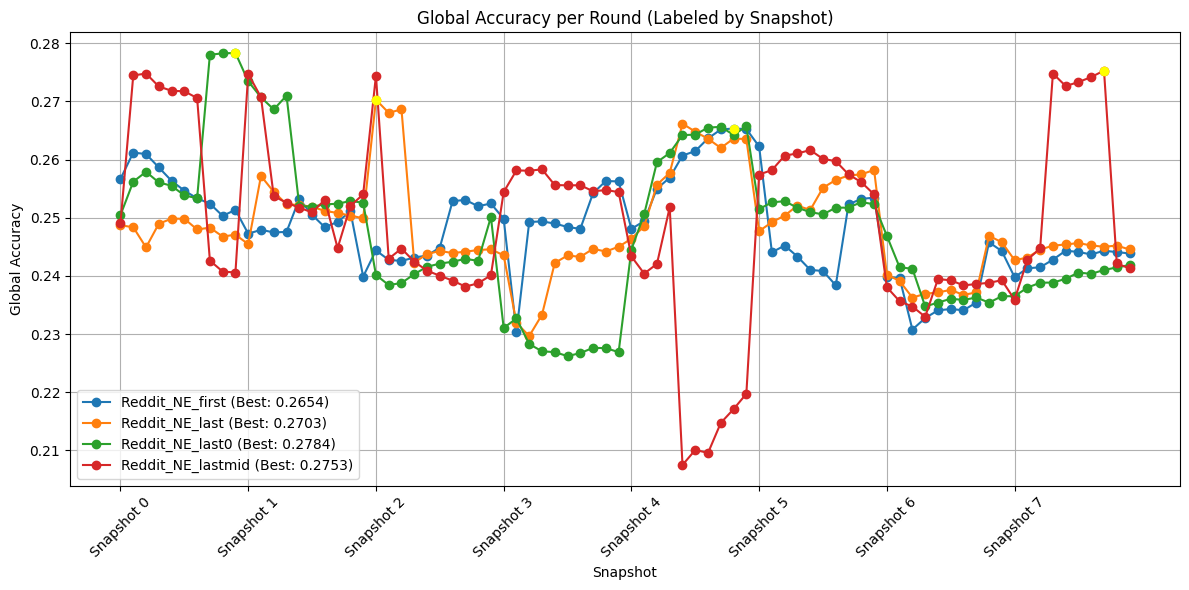

In [14]:
compare = ["Reddit_NE_first", "Reddit_NE_last", "Reddit_NE_last0", "Reddit_NE_lastmid"]
data_list = []
for strat in compare:
    _, snapshot_to_global_accs, _, _, _, _, _, _ = parse_log_file(experiment_to_results_path[strat])
    modified_dict = {}
    for snapshot in snapshot_to_global_accs:
        modified_dict[snapshot] = [[[i] for i in snapshot_to_global_accs[snapshot]]]
    data_list.append(modified_dict)

plot_multiple_global_accuracies_with_snapshot_xticks(data_list, compare)

### Compute the Average Global Accuracy

We obtain the best accuracy of each snapshot, and take an average of them.

In [15]:
import re
import os
from collections import defaultdict

def extract_best_f1_from_file(file_path):
    best_f1_scores = []

    with open(file_path, 'r') as f:
        for line in f:
            if "Snapshot Ends." in line and "Best Metrics" in line:
                # Use regex to extract best_f1
                match = re.search(r"'best_f1': ([0-9.]+)", line)
                if match:
                    best_f1 = float(match.group(1))
                    best_f1_scores.append(best_f1)

    return best_f1_scores

def summarize_best_f1_across_files(files):
    data = []

    for file in files:
        best_f1s = extract_best_f1_from_file(experiment_to_results_path[file])
        avg_f1 = sum(best_f1s) / len(best_f1s) if best_f1s else 0.0
        data.append({
            'Label': file,
            'File': os.path.basename(file),
            'Snapshots': len(best_f1s),
            'Avg Best F1': round(avg_f1, 4)
        })

    df = pd.DataFrame(data)
    return df

def print_best_f1_table(files, save_path=None):
    df = summarize_best_f1_across_files(files)
    print(df)

    if save_path:
        df.to_csv(save_path, index=False)
        print(f"\nSaved table to {save_path}")

In [16]:
compare = ["DBLP5_NE_first", "DBLP5_NE_last", "DBLP5_NE_last0", "DBLP5_NE_lastmid"]
print_best_f1_table(compare)

              Label              File  Snapshots  Avg Best F1
0    DBLP5_NE_first    DBLP5_NE_first          8       0.7136
1     DBLP5_NE_last     DBLP5_NE_last          8       0.7167
2    DBLP5_NE_last0    DBLP5_NE_last0          8       0.7156
3  DBLP5_NE_lastmid  DBLP5_NE_lastmid          8       0.7074
